[![Open In Colab](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-colab.svg)](https://colab.research.google.com/github/crunchdao/quickstarters/blob/master/competitions/structural-break/quickstarters/baseline/baseline.ipynb)
[![Open In Kaggle](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/badge/open-in-kaggle.svg)](https://www.kaggle.com/code/crunchdao/structural-break-baseline)

In [4]:
%pip install crunch-cli --upgrade --quiet --progress-bar off
!crunch setup-notebook structural-break YG9XNMn0AZX62txkZoaqySbG

crunch-cli, version 7.4.0
delete /content/.crunchdao
you appear to have never submitted code before
data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
                                
---
Success! Your environment has been correctly setup.
Next recommended actions:
1. Load the Crunch Toolings: `crunch = crunch.load_notebook()`
2. Execute the cells with your code
3. Run a test: `crunch.test()`
4. Downloa

In [3]:
%pip install ruptures --quiet

# Your model

## Setup

In [11]:
import os
import typing

# Import your dependencies
import joblib
import pandas as pd
import scipy
import sklearn.metrics

import os
import typing
import joblib
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import ruptures as rpt
import xgboost as xgb
# seraj
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [6]:
import crunch

# Load the Crunch Toolings
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>

cli version: 7.4.0
available ram: 12.67 gb
available cpu: 2 core
----


## Understanding the Data

The dataset consists of univariate time series, each containing ~2,000-5,000 values with a designated boundary point. For each time series, you need to determine whether a structural break occurred at this boundary point.

The data was downloaded when you setup your local environment and is now available in the `data/` directory.

In [7]:
# Load the data simply
X_train, y_train, X_test = crunch.load_data()

data/X_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_train.parquet (204327238 bytes)
data/X_train.parquet: already exists, file length match
data/X_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/X_test.reduced.parquet (2380918 bytes)
data/X_test.reduced.parquet: already exists, file length match
data/y_train.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_train.parquet (61003 bytes)
data/y_train.parquet: already exists, file length match
data/y_test.reduced.parquet: download from https:crunchdao--competition--production.s3-accelerate.amazonaws.com/data-releases/146/y_test.reduced.parquet (2655 bytes)
data/y_test.reduced.parquet: already exists, file length match


In [12]:
X_train

value  period
id    time                  
0     0    -0.005564       0
      1     0.003705       0
      2     0.013164       0
      3     0.007151       0
      4    -0.009979       0
...              ...     ...
10000 2134  0.001137       1
      2135  0.003526       1
      2136  0.000687       1
      2137  0.001640       1
      2138  0.001074       1

[23715734 rows x 2 columns]

### ***Morteza***

In [12]:
def _feature_names():
    """
    Returns all feature names in order for consistent DataFrame construction.
    """
    return [
        "mean_pre", "mean_post", "std_pre", "std_post",
        "skew_pre", "skew_post", "kurt_pre", "kurt_post",
        "diff_mean", "diff_std", "ratio_std",
        "t_stat", "t_pval", "ks_stat", "ks_pval",
        "slope_pre", "slope_post", "diff_slope",
        "acf1_pre", "acf1_post", "diff_acf1",
        "cp_distance", "var_ratio"
    ]

def _extract_features_one_series(df: pd.DataFrame) -> dict:
    """
    Extracts features for one time series given `value` and `period` columns.
    """
    # Ensure sorted by time
    if "time" in df.columns:
        df = df.sort_values("time")

    values = df["value"].values
    period = df["period"].values

    # Find break point (first 1)
    if np.any(period == 1):
        idx_break = np.argmax(period == 1)
    else:
        # No break marker → use empty post
        idx_break = len(values)

    pre = values[:idx_break]
    post = values[idx_break:]

    # Handle edge cases
    if len(pre) < 3 or len(post) < 3:
        # Not enough data to compute most stats → fill with NaNs
        return {f: np.nan for f in _feature_names()}

    feats = {}

    # Basic descriptive stats
    feats["mean_pre"] = np.mean(pre)
    feats["mean_post"] = np.mean(post)
    feats["std_pre"] = np.std(pre, ddof=1)
    feats["std_post"] = np.std(post, ddof=1)
    feats["skew_pre"] = stats.skew(pre)
    feats["skew_post"] = stats.skew(post)
    feats["kurt_pre"] = stats.kurtosis(pre)
    feats["kurt_post"] = stats.kurtosis(post)

    feats["diff_mean"] = feats["mean_post"] - feats["mean_pre"]
    feats["diff_std"] = feats["std_post"] - feats["std_pre"]
    feats["ratio_std"] = feats["std_post"] / (feats["std_pre"] + 1e-6)

    # Statistical tests
    t_res = stats.ttest_ind(post, pre, equal_var=False)
    feats["t_stat"] = t_res.statistic
    feats["t_pval"] = t_res.pvalue
    ks_res = stats.ks_2samp(post, pre)
    feats["ks_stat"] = ks_res.statistic
    feats["ks_pval"] = ks_res.pvalue

    # Trend slopes (linear regression slope)
    def _slope(series):
        x = np.arange(len(series))
        X = add_constant(x)
        return OLS(series, X).fit().params[1]

    feats["slope_pre"] = _slope(pre)
    feats["slope_post"] = _slope(post)
    feats["diff_slope"] = feats["slope_post"] - feats["slope_pre"]

    # Autocorrelation change (lag 1)
    def _acf1(series):
        return acf(series, nlags=1, fft=False)[1] if len(series) > 1 else np.nan

    feats["acf1_pre"] = _acf1(pre)
    feats["acf1_post"] = _acf1(post)
    feats["diff_acf1"] = feats["acf1_post"] - feats["acf1_pre"]

    # Change-point detection metrics (ruptures - CUSUM, L2)
    try:
        model = rpt.Binseg(model="l2").fit(values)
        change_points = model.predict(n_bkps=2)  # force 1 breakpoint
        # Distance from detected cp to suspected idx_break
        feats["cp_distance"] = min(abs(cp - idx_break) for cp in change_points)
    except Exception:
        feats["cp_distance"] = np.nan

    try:
        # Maximum likelihood ratio (simple: variance change)
        var_ratio = np.var(post) / (np.var(pre) + 1e-6)
        feats["var_ratio"] = var_ratio
    except Exception:
        feats["var_ratio"] = np.nan

    return feats

### ***Seraj***

In [20]:
import numpy as np
import pandas as pd
from scipy import stats, signal
from scipy.stats import skew, kurtosis, wasserstein_distance
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import LinearRegression

In [21]:
# Optional imports (install if you want wavelets / more)
try:
    import pywt
    _have_pywt = True
except Exception:
    _have_pywt = False

EPS = 1e-8

def hurst_exponent(ts):
    # Simple R/S Hurst exponent estimate
    ts = np.asarray(ts)
    n = len(ts)
    if n < 20:
        return np.nan
    max_k = int(np.floor(n/2))
    ks = np.unique(np.floor(np.logspace(np.log10(5), np.log10(max_k), num=20)).astype(int))
    rs = []
    for k in ks:
        if k < 5:
            continue
        num_segments = n // k
        seg_rs = []
        for i in range(num_segments):
            seg = ts[i*k:(i+1)*k]
            mean = seg.mean()
            Y = np.cumsum(seg - mean)
            R = Y.max() - Y.min()
            S = seg.std(ddof=1)
            if S > 0:
                seg_rs.append(R / S)
        if len(seg_rs) > 0:
            rs.append(np.mean(seg_rs))
    ks = ks[:len(rs)]
    if len(ks) < 2:
        return np.nan
    # fit log(R/S) ~ H * log(k)
    H = np.polyfit(np.log(ks), np.log(rs), 1)[0]
    return H

def spectral_entropy(psd, base=2):
    psd = np.asarray(psd)
    psd = psd / (psd.sum() + EPS)
    se = -np.sum(psd * np.log(psd + EPS)) / np.log(base)
    return se

def compute_basic_stats(x):
    x = np.asarray(x)
    return {
        "mean": np.nanmean(x),
        "median": np.nanmedian(x),
        "std": np.nanstd(x, ddof=1),
        "mad": np.nanmedian(np.abs(x - np.nanmedian(x))),
        "min": np.nanmin(x),
        "max": np.nanmax(x),
        "skew": skew(x, bias=False),
        "kurt": kurtosis(x, fisher=True, bias=False),
        "p10": np.nanpercentile(x, 10),
        "p25": np.nanpercentile(x, 25),
        "p75": np.nanpercentile(x, 75),
        "p90": np.nanpercentile(x, 90),
        "count": len(x),
        "sum": np.nansum(x),
    }

def extract_features_for_ts(df):
    """
    df: DataFrame with columns ['value','period'] (period is 0 before, 1 after)
    returns: dict of features
    """
    vals_before = df.loc[df['period'] == 0, 'value'].values
    vals_after = df.loc[df['period'] == 1, 'value'].values

    features = {}
    # Basic stats
    b_stats = compute_basic_stats(vals_before)
    a_stats = compute_basic_stats(vals_after)
    for k, v in b_stats.items():
        features[f"{k}_before"] = v
    for k, v in a_stats.items():
        features[f"{k}_after"] = v
    for k in b_stats.keys():
        try:
            features[f"{k}_diff"] = a_stats[k] - b_stats[k]
            features[f"{k}_ratio"] = (a_stats[k] / (b_stats[k] + EPS))
        except Exception:
            features[f"{k}_diff"] = np.nan
            features[f"{k}_ratio"] = np.nan

    # Distributional tests
    try:
        tstat, pval = stats.ttest_ind(vals_before, vals_after, equal_var=False, nan_policy='omit')
        features['t_pvalue'] = pval
        features['t_stat'] = tstat
    except Exception:
        features['t_pvalue'] = np.nan
        features['t_stat'] = np.nan

    try:
        ks_stat, ks_p = stats.ks_2samp(vals_before, vals_after)
        features['ks_stat'] = ks_stat
        features['ks_p'] = ks_p
    except Exception:
        features['ks_stat'] = np.nan
        features['ks_p'] = np.nan

    # Wasserstein (earth-mover) distance
    try:
        features['wass'] = wasserstein_distance(vals_before, vals_after)
    except Exception:
        features['wass'] = np.nan

    # Histogram-KL divergence (discrete approx)
    try:
        bins = 50
        minv = min(np.nanmin(vals_before), np.nanmin(vals_after))
        maxv = max(np.nanmax(vals_before), np.nanmax(vals_after))
        hist_b, _ = np.histogram(vals_before, bins=bins, range=(minv, maxv), density=True)
        hist_a, _ = np.histogram(vals_after, bins=bins, range=(minv, maxv), density=True)
        p = hist_b + EPS
        q = hist_a + EPS
        kl = np.sum(p * np.log(p / q))
        features['kl_hist'] = kl
    except Exception:
        features['kl_hist'] = np.nan

    # Autocorrelation & PACF features (several lags)
    try:
        lags = [1,2,3,5,10]
        acf_all = acf(df['value'].values, nlags=max(lags)+1, fft=True, missing='none')
        for lag in lags:
            features[f"acf_lag{lag}"] = acf_all[lag] if lag < len(acf_all) else np.nan
    except Exception:
        for lag in [1,2,3,5,10]:
            features[f"acf_lag{lag}"] = np.nan

    try:
        pacf_vals = pacf(df['value'].values, nlags=10, method='ywunbiased')
        for lag in [1,2,3,5]:
            features[f"pacf_lag{lag}"] = pacf_vals[lag] if lag < len(pacf_vals) else np.nan
    except Exception:
        for lag in [1,2,3,5]:
            features[f"pacf_lag{lag}"] = np.nan

    # Fit small AR models on each half and record coefficients & residual stats
    def fit_ar(x, lags=3):
        try:
            if len(x) < (lags + 5):
                return [np.nan]*lags, np.nan
            ar = AutoReg(x, lags=lags, old_names=False).fit()
            coeffs = ar.params[1:].tolist()  # exclude intercept
            resid_std = np.std(ar.resid, ddof=1)
            # pad
            coeffs = coeffs + [np.nan] * (lags - len(coeffs))
            return coeffs, resid_std
        except Exception:
            return [np.nan]*lags, np.nan

    ar_before_coef, ar_before_resid = fit_ar(vals_before, lags=3)
    ar_after_coef, ar_after_resid = fit_ar(vals_after, lags=3)
    for i, c in enumerate(ar_before_coef, 1):
        features[f"ar_b_coef_lag{i}"] = c
    for i, c in enumerate(ar_after_coef, 1):
        features[f"ar_a_coef_lag{i}"] = c
    features['ar_resid_std_diff'] = (ar_after_resid - ar_before_resid) if (not np.isnan(ar_after_resid) and not np.isnan(ar_before_resid)) else np.nan

    # Stationarity tests
    try:
        adf_b = adfuller(vals_before, maxlag=10, autolag='AIC', regression='c', store=False)
        features['adf_stat_before'] = adf_b[0]
        features['adf_p_before'] = adf_b[1]
    except Exception:
        features['adf_stat_before'] = np.nan
        features['adf_p_before'] = np.nan

    try:
        adf_a = adfuller(vals_after, maxlag=10, autolag='AIC', regression='c', store=False)
        features['adf_stat_after'] = adf_a[0]
        features['adf_p_after'] = adf_a[1]
    except Exception:
        features['adf_stat_after'] = np.nan
        features['adf_p_after'] = np.nan

    # Ljung-Box to detect autocorrelation (use multiple lags)
    try:
        lb_b = acorr_ljungbox(vals_before, lags=[10], return_df=True)
        lb_a = acorr_ljungbox(vals_after, lags=[10], return_df=True)
        features['ljungbox_p_before'] = float(lb_b['lb_pvalue'].iloc[-1])
        features['ljungbox_p_after'] = float(lb_a['lb_pvalue'].iloc[-1])
    except Exception:
        features['ljungbox_p_before'] = np.nan
        features['ljungbox_p_after'] = np.nan

    # Rolling features around boundary (local behavior)
    try:
        window = min(50, max(5, int(len(df)/10)))
        rolled = pd.Series(df['value'].values).rolling(window=window)
        features['rolling_mean_last'] = rolled.mean().iloc[-1]
        features['rolling_std_last'] = rolled.std(ddof=1).iloc[-1]
        features['rolling_skew_last'] = rolled.apply(lambda x: skew(x) if len(x)>2 else np.nan).iloc[-1]
    except Exception:
        features['rolling_mean_last'] = np.nan
        features['rolling_std_last'] = np.nan
        features['rolling_skew_last'] = np.nan

    # Trend slope before/after using linear regression (captures local deterministic trend)
    def slope(x):
        try:
            n = len(x)
            if n < 3:
                return np.nan
            t = np.arange(n).reshape(-1,1)
            lr = LinearRegression().fit(t, x)
            return float(lr.coef_[0])
        except Exception:
            return np.nan

    features['slope_before'] = slope(vals_before)
    features['slope_after'] = slope(vals_after)
    features['slope_diff'] = features['slope_after'] - features['slope_before']

    # CUSUM statistic around boundary
    try:
        full = df['value'].values
        mu = np.mean(full)
        cusum = np.cumsum(full - mu)
        # measure magnitude near boundary: max abs cusum in first half vs second half
        mid = np.argmax(df['period'].values)  # index of first 1
        if mid is None or mid <= 0 or mid >= len(full)-1:
            mid = len(vals_before)
        features['cusum_max_before'] = np.max(np.abs(cusum[:mid]))
        features['cusum_max_after'] = np.max(np.abs(cusum[mid:]))
        features['cusum_diff'] = features['cusum_max_after'] - features['cusum_max_before']
    except Exception:
        features['cusum_max_before'] = np.nan
        features['cusum_max_after'] = np.nan
        features['cusum_diff'] = np.nan

    # Spectral features: PSD + dominant frequency + spectral entropy
    try:
        f, Pxx = signal.welch(df['value'].values, nperseg=min(256, len(df)))
        # total power
        features['psd_power_total'] = np.sum(Pxx)
        # dominant frequency
        idx = np.argmax(Pxx)
        features['psd_dominant_freq'] = float(f[idx])
        features['psd_entropy'] = spectral_entropy(Pxx)
        # ratio low/high freq energy (split at median freq)
        midf = np.median(f)
        lowp = np.sum(Pxx[f <= midf])
        highp = np.sum(Pxx[f > midf])
        features['psd_low_high_ratio'] = lowp / (highp + EPS)
    except Exception:
        features['psd_power_total'] = np.nan
        features['psd_dominant_freq'] = np.nan
        features['psd_entropy'] = np.nan
        features['psd_low_high_ratio'] = np.nan

    # Wavelet band energy (optional)
    if _have_pywt:
        try:
            coeffs = pywt.wavedec(df['value'].values, 'db4', level=3)
            for i, c in enumerate(coeffs):
                features[f"wav_energy_level_{i}"] = np.sum(np.square(c))
        except Exception:
            for i in range(4):
                features[f"wav_energy_level_{i}"] = np.nan
    else:
        # mark as missing if not available
        for i in range(4):
            features[f"wav_energy_level_{i}"] = np.nan

    # Complexity: Hurst approximate
    try:
        features['hurst'] = hurst_exponent(df['value'].values)
    except Exception:
        features['hurst'] = np.nan

    # optionally: sample entropy / permutation entropy (not implemented here; can add via 'antropy' or custom impl.)

    return features



import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
import joblib
import os

# -------------------------
# Feature Extraction
# -------------------------
def extract_features_for_series(df: pd.DataFrame) -> dict:
    before = df.loc[df['period'] == 0, 'value'].values
    after = df.loc[df['period'] == 1, 'value'].values
    features = {}

    # 1. Mean difference
    features["mean_diff"] = np.mean(after) - np.mean(before)

    # 2. Variance ratio
    var_b = np.var(before) if len(before) > 1 else 1e-6
    var_a = np.var(after) if len(after) > 1 else 1e-6
    features["var_ratio"] = var_a / var_b if var_b > 0 else np.nan

    # 3. Autocorrelation difference
    def autocorr(x, lag=1):
        return np.corrcoef(x[:-lag], x[lag:])[0, 1] if len(x) > lag else 0
    features["autocorr_diff"] = autocorr(after, 1) - autocorr(before, 1)

    # 4. Skewness difference
    features["skew_diff"] = stats.skew(after) - stats.skew(before)

    # 5. Kurtosis difference
    features["kurt_diff"] = stats.kurtosis(after) - stats.kurtosis(before)

    # 6. Trend slope difference
    def slope_estimate(x):
        if len(x) < 3: return 0
        t = np.arange(len(x)).reshape(-1, 1)
        return LinearRegression().fit(t, x).coef_[0]
    features["slope_diff"] = slope_estimate(after) - slope_estimate(before)

    # 7. ADF statistic difference
    def safe_adf(x):
        try:
            return adfuller(x, maxlag=1, autolag=None)[0]
        except Exception:
            return 0
    features["adf_diff"] = safe_adf(after) - safe_adf(before)

    # 8. KS statistic
    try:
        ks_stat, _ = stats.ks_2samp(before, after)
    except Exception:
        ks_stat = 0
    features["ks_stat"] = ks_stat

    # 9. Rolling variance jump
    def rolling_var(x, window=50):
        if len(x) < window: return np.var(x)
        return pd.Series(x).rolling(window).var().dropna().iloc[-1]
    rv_before = rolling_var(before, window=min(50, len(before)//2))
    rv_after = rolling_var(after, window=min(50, len(after)//2))
    features["rolling_var_jump"] = rv_after - rv_before

    # 10. CUSUM statistics
    def cusum_stat(x):
        mean_x = np.mean(x)
        return np.max(np.abs(np.cumsum(x - mean_x)))
    features["cusum_before"] = cusum_stat(before)
    features["cusum_after"] = cusum_stat(after)
    features["cusum_diff"] = features["cusum_after"] - features["cusum_before"]

    return features


def build_feature_matrix(X: pd.DataFrame) -> pd.DataFrame:
    feats = []
    for ts_id, df in tqdm(X.groupby(level="id")):
        df = df.droplevel("id")
        f = extract_features_for_series(df)
        f["id"] = ts_id
        feats.append(f)
    return pd.DataFrame(feats).set_index("id").fillna(0)


# -------------------------
# Competition Train & Infer
# -------------------------
from xgboost import XGBClassifier

def train(X_train, y_train, model_directory_path: str):
    X_feats = build_feature_matrix(X_train)
    y = y_train.loc[X_feats.index]

    model = XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="auc",
        tree_method="hist"
    )
    model.fit(X_feats, y)

    joblib.dump(model, os.path.join(model_directory_path, "model.joblib"))

def infer(X_test, model_directory_path: str):
    model = joblib.load(os.path.join(model_directory_path, "model.joblib"))
    yield  # Ready signal

    for dataset in X_test:
        df = dataset.reset_index(level=0, drop=True)
        feats = extract_features_for_series(df)
        X_feats = pd.DataFrame([feats]).fillna(0)
        pred = model.predict_proba(X_feats)[:, 1][0]
        yield pred


In [31]:
feature_rows = []
ids = []

for ts_id, group in tqdm(X_train.loc[:10].groupby(level=0)):
    df_id = group.reset_index(level=0, drop=True).reset_index()
    feats = extract_features_for_ts(df_id)
    feature_rows.append(feats)
    ids.append(ts_id)

100%|██████████| 11/11 [00:23<00:00,  2.16s/it]


In [32]:
# pd.DataFrame(feature_rows, index=ids)
X_feats = pd.DataFrame(feature_rows, index=ids)
y_aligned = y_train.loc[X_feats.index].astype(int)

# Handle NaNs (fill with 0 or median)
X_feats = X_feats.fillna(0)

In [33]:
X_feats

,mean_before,median_before,std_before,mad_before,min_before,max_before,skew_before,kurt_before,p10_before,p25_before,...,cusum_diff,psd_power_total,psd_dominant_freq,psd_entropy,psd_low_high_ratio,wav_energy_level_0,wav_energy_level_1,wav_energy_level_2,wav_energy_level_3,hurst
0,0.000015,0.000210,0.006987,0.004778,-0.022088,0.028202,0.009004,0.082124,-0.008832,-0.004857,...,-0.002959,0.012427,0.332031,6.851694,0.702927,0.003097,0.008333,0.021104,0.047743,0.300239
1,0.000128,0.000123,0.002524,0.001275,-0.017693,0.021874,0.132526,6.383838,-0.002619,-0.001157,...,-0.094812,0.001588,0.210938,6.925121,1.219945,0.001871,0.001717,0.004937,0.007043,0.584009
2,0.000389,0.000677,0.017221,0.009411,-0.085878,0.087720,0.047030,2.707445,-0.019505,-0.008929,...,-0.400152,0.088354,0.390625,6.932556,0.688917,0.096876,0.104694,0.213681,0.557235,0.522075
3,0.000381,0.000271,0.008388,0.004837,-0.043547,0.064906,0.258870,3.762727,-0.009287,-0.004358,...,-0.225202,0.019330,0.472656,6.966283,0.999540,0.032508,0.024342,0.056308,0.105092,0.548219
4,-0.000016,0.000022,0.003314,0.002259,-0.010066,0.009546,-0.042721,-0.123805,-0.004220,-0.002274,...,0.005012,0.002823,0.023438,6.446211,4.399411,0.009091,0.005076,0.005007,0.004539,0.671544
5,0.002054,0.001773,0.018694,0.010514,-0.064735,0.236065,1.515198,18.325019,-0.019428,-0.008792,...,-0.427930,0.077783,0.195312,6.932941,1.015003,0.085161,0.075105,0.184807,0.374962,0.570932
6,0.000254,0.000167,0.009447,0.004760,-0.035622,0.049326,0.190483,2.288670,-0.010273,-0.004638,...,-0.228226,0.022034,0.292969,6.952715,1.142982,0.032378,0.027262,0.056088,0.103120,0.601600
7,0.000387,-0.007585,0.043258,0.019236,-0.191919,0.278261,1.374711,7.759696,-0.037037,-0.019370,...,0.462909,0.440452,0.011719,6.935749,1.143780,0.781070,0.528042,1.096020,2.137584,0.646490
8,0.000120,0.000079,0.001484,0.000623,-0.013757,0.012005,0.472947,17.730686,-0.001164,-0.000543,...,-0.018012,0.000501,0.128906,6.948804,1.011328,0.000806,0.000633,0.000994,0.002214,0.499336
9,-0.000072,-0.000844,0.019714,0.010206,-0.077816,0.100680,0.404507,2.763610,-0.022535,-0.010798,...,-0.622284,0.090946,0.023438,6.952831,0.920182,0.155237,0.133276,0.241680,0.554657,0.605661


In [45]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    """
    Train XGBoost model on extracted statistical features.
    X_train: MultiIndex (id, time), columns = [value, period]
    y_train: index = id, values = True/False
    """
    feature_rows = []
    ids = []

    for ts_id, group in tqdm(X_train.loc[:].groupby(level=0)):
        df_id = group.reset_index(level=0, drop=True).reset_index()
        feats = extract_features_for_ts(df_id)
        feature_rows.append(feats)
        ids.append(ts_id)

    # pd.DataFrame(feature_rows, index=ids)
    X_feats = pd.DataFrame(feature_rows, index=ids)
    y_aligned = y_train.loc[X_feats.index].astype(int)

    # Handle NaNs (fill with 0 or median)
    X_feats = X_feats.fillna(0)

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=100,
        max_depth=6,
        learning_rate=0.015,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_feats, y_aligned)

    os.makedirs(model_directory_path, exist_ok=True)
    joblib.dump((model, _feature_names()), os.path.join(model_directory_path, 'model.joblib'))
    return model

value  period
id  time                  
0   0    -0.005564       0
    1     0.003705       0
    2     0.013164       0
    3     0.007151       0
    4    -0.009979       0
...            ...     ...
500 2326 -0.020000       1
    2327 -0.001276       1
    2328  0.019157       1
    2329 -0.002506       1
    2330 -0.010050       1

[1197767 rows x 2 columns]

In [46]:
model = train(
    X_train=X_train.loc[:500],
    y_train=y_train,
    model_directory_path=''
)

100%|██████████| 501/501 [16:30<00:00,  1.98s/it]
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:18:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


FileNotFoundError: [Errno 2] No such file or directory: ''

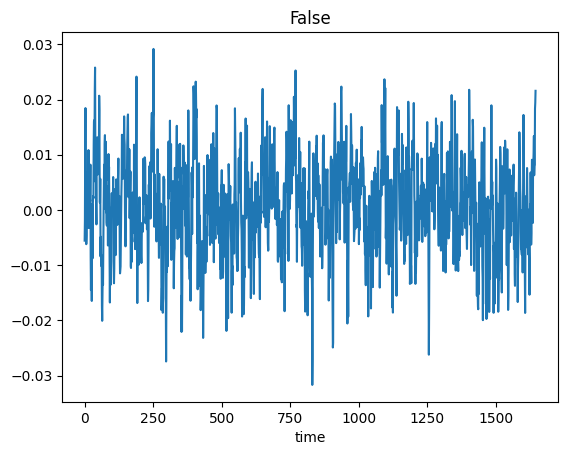

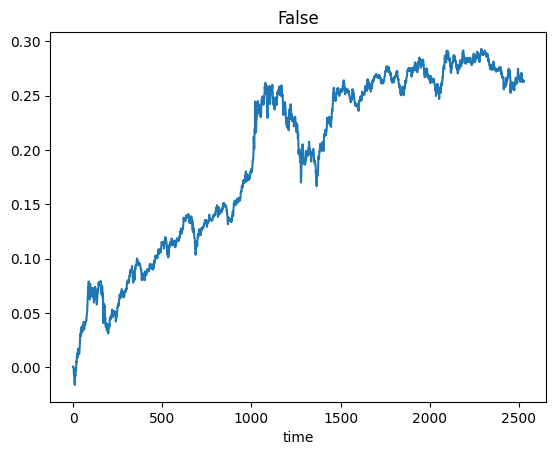

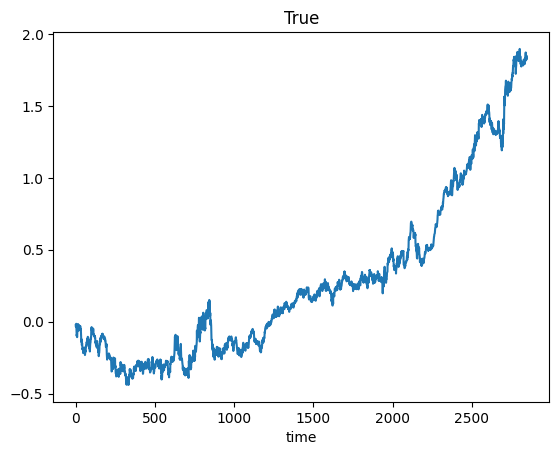

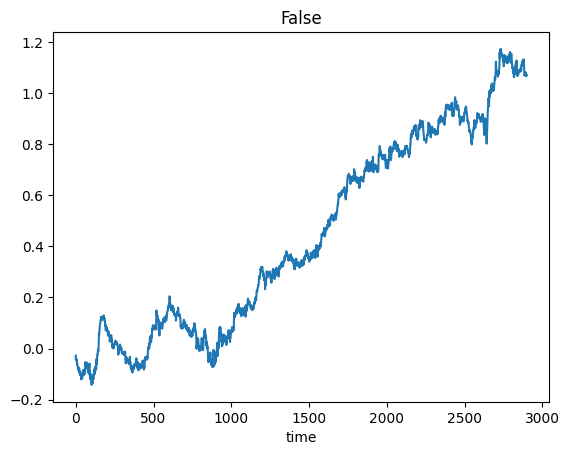

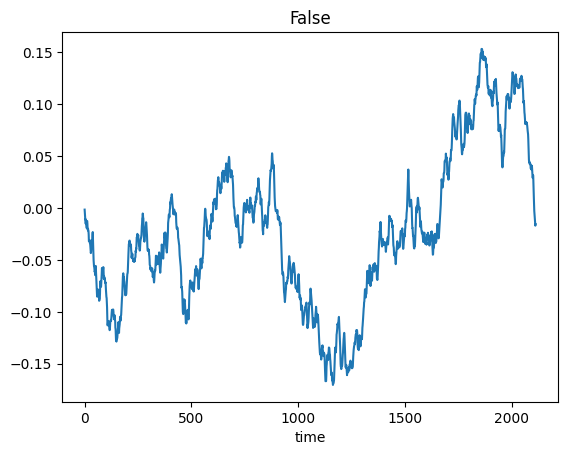

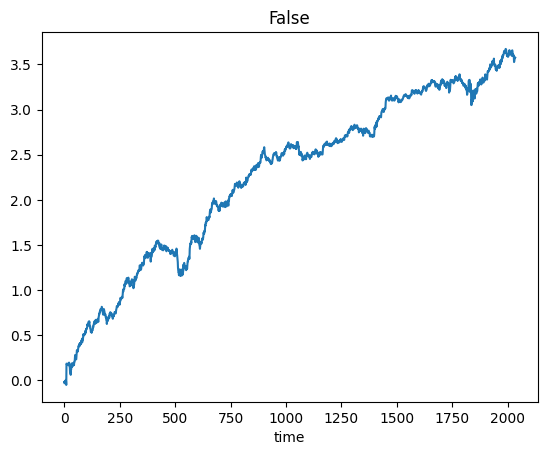

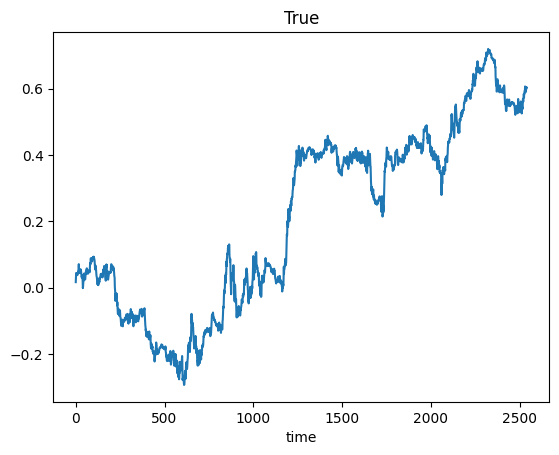

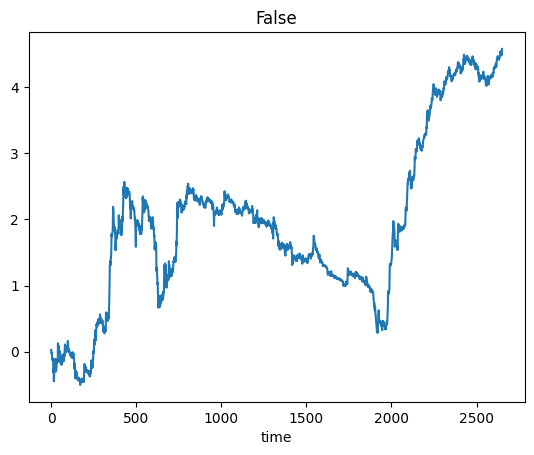

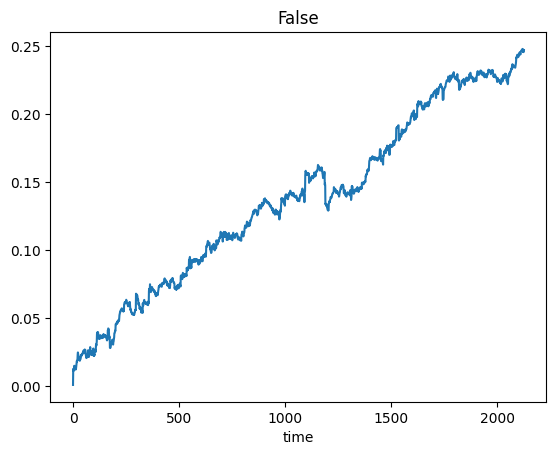

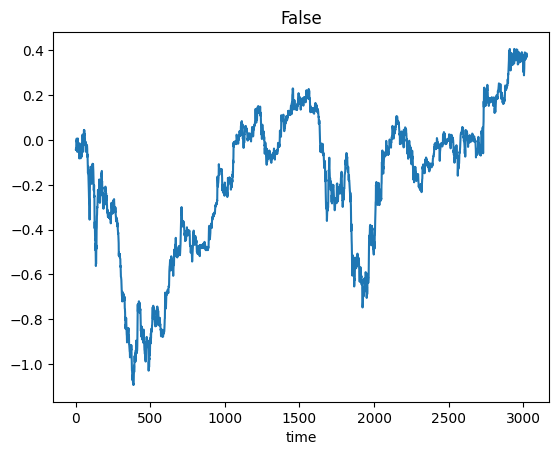

In [20]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    """
    Predict probability of structural break for each time series in X_test.
    X_test: iterable of pd.DataFrame, each one has columns [value, period] and maybe 'time'.
    """
    model, feat_names = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Ready signal

    for dataset in X_test:
        feats = _extract_features_one_series(dataset)
        X_feats = pd.DataFrame([feats], columns=feat_names).fillna(0)
        prob = model.predict_proba(X_feats)[:, 1][0]
        yield prob

### Understanding `X_train`

The training data is structured as a pandas DataFrame with a MultiIndex:

**Index Levels:**
- `id`: Identifies the unique time series
- `time`: The timestep within each time series

**Columns:**
- `value`: The actual time series value at each timestep
- `period`: A binary indicator where `0` represents the **period before** the boundary point, and `1` represents the **period after** the boundary point

In [7]:
X_test[0]

value  period
id    time                  
10001 0     0.010753       0
      1    -0.031915       0
      2    -0.010989       0
      3    -0.011111       0
      4     0.011236       0
...              ...     ...
      2774 -0.013937       1
      2775 -0.015649       1
      2776 -0.009744       1
      2777  0.025375       1
      2778 -0.001515       1

[2779 rows x 2 columns]

### Understanding `y_train`

This is a simple `pandas.Series` that tells if a dataset id has a structural breakpoint or not.

**Index:**
- `id`: the ID of the dataset

**Value:**
- `structural_breakpoint`: Boolean indicating whether a structural break occurred (`True`) or not (`False`)

In [ ]:
y_train

### Understanding `X_test`

The test data is provided as a **`list` of `pandas.DataFrame`s** with the same format as [`X_train`](#understanding-X_test).

It is structured as a list to encourage processing records one by one, which will be mandatory in the `infer()` function.

In [29]:
print("Number of datasets:", len(X_test))

Number of datasets: 101


In [ ]:
X_test[0]

## Strategy Implementation

There are multiple approaches you can take to detect structural breaks:

1. **Statistical Tests**: Compare distributions before and after the boundary point;
2. **Feature Engineering**: Extract features from both segments for comparison;
3. **Time Series Modeling**: Detect deviations from expected patterns;
4. **Machine Learning**: Train models to recognize break patterns from labeled examples.

The baseline implementation below uses a simple statistical approach: a t-test to compare the distributions before and after the boundary point.

### The `train()` Function

In this function, you build and train your model for making inferences on the test data. Your model must be stored in the `model_directory_path`.

The baseline implementation below doesn't require a pre-trained model, as it uses a statistical test that will be computed at inference time.

In [ ]:
def train(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_directory_path: str,
):
    # For our baseline t-test approach, we don't need to train a model
    # This is essentially an unsupervised approach calculated at inference time
    model = None

    # You could enhance this by training an actual model, for example:
    # 1. Extract features from before/after segments of each time series
    # 2. Train a classifier using these features and y_train labels
    # 3. Save the trained model

    joblib.dump(model, os.path.join(model_directory_path, 'model.joblib'))

### The `infer()` Function

In the inference function, your trained model (if any) is loaded and used to make predictions on test data.

**Important workflow:**
1. Load your model;
2. Use the `yield` statement to signal readiness to the runner;
3. Process each dataset one by one within the for loop;
4. For each dataset, use `yield prediction` to return your prediction.

**Note:** The datasets can only be iterated once!

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    model = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Mark as ready

    # X_test can only be iterated once.
    # Before getting the next dataset, you must predict the current one.
    for dataset in X_test:
        # Baseline approach: Compute t-test between values before and after boundary point
        # The negative p-value is used as our score - smaller p-values (larger negative numbers)
        # indicate more evidence against the null hypothesis that distributions are the same,
        # suggesting a structural break
        def t_test(u: pd.DataFrame):
            return -scipy.stats.ttest_ind(
                u["value"][u["period"] == 0],  # Values before boundary point
                u["value"][u["period"] == 1],  # Values after boundary point
            ).pvalue

        prediction = t_test(dataset)
        yield prediction  # Send the prediction for the current dataset

        # Note: This baseline approach uses a t-test to compare the distributions
        # before and after the boundary point. A smaller p-value (larger negative number)
        # suggests stronger evidence that the distributions are different,
        # indicating a potential structural break.

In [ ]:
def infer(
    X_test: typing.Iterable[pd.DataFrame],
    model_directory_path: str,
):
    """
    Predict probability of structural break for each time series in X_test.
    X_test: iterable of pd.DataFrame, each one has columns [value, period] and maybe 'time'.
    """
    model, feat_names = joblib.load(os.path.join(model_directory_path, 'model.joblib'))

    yield  # Ready signal

    for dataset in X_test:
        feats = _extract_features_one_series(dataset)
        X_feats = pd.DataFrame([feats], columns=feat_names).fillna(0)
        prob = model.predict_proba(X_feats)[:, 1][0]
        yield prob

## Local testing

To make sure your `train()` and `infer()` function are working properly, you can call the `crunch.test()` function that will reproduce the cloud environment locally. <br />
Even if it is not perfect, it should give you a quick idea if your model is working properly.

In [ ]:
crunch.test(
    # Uncomment to disable the train
    # force_first_train=False,

    # Uncomment to disable the determinism check
    # no_determinism_check=True,
)

## Results

Once the local tester is done, you can preview the result stored in `data/prediction.parquet`.

In [ ]:
prediction = pd.read_parquet("data/prediction.parquet")
prediction

### Local scoring

You can call the function that the system uses to estimate your score locally.

In [ ]:
# Load the targets
target = pd.read_parquet("data/y_test.reduced.parquet")["structural_breakpoint"]

# Call the scoring function
sklearn.metrics.roc_auc_score(
    target,
    prediction,
)

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/structural-break/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)